# Fáza 3 IAU - Daniela Paľuchová 50%, Mark Bartalos 50% 

Vyriešené veci z predchádzajúcej fázy

In [157]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import export_graphviz
from sklearn import tree
import random
import numpy as np
from graphviz import Source
from IPython.display import SVG
from IPython.display import HTML
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [158]:
training = pd.read_csv("trenovaci.csv", sep=',')
target = pd.read_csv("trenovaci_target.csv", sep=',')
training

,pct_wild_mouse,screen_height,pct_input,pct_scrandom,pct_scroll_move,pct_click_product_info,wild_mouse_duration,total_load_time,pct_click,screen_width,...,scroll_move_total_rel_distance,page_activity_duration,mouse_move_total_rel_distance,browser_name,pct_rage_click,session_duration,pct_mouse_click,job,race,age
0,59.56562,2,0.05917,48.05874,39.37553,66.21904,13.32802,5.93412,19.29164,2,...,21.28298,18.00126,15.52013,6,41.19641,106.97645,16.06948,3,1,60
1,57.12588,5,0.62610,27.98295,41.97408,58.58313,15.04745,4.19728,12.80114,1,...,18.49826,17.48769,13.88568,4,40.01657,135.12413,18.11505,3,1,60
2,36.23258,5,0.87819,44.02044,46.59896,34.35303,15.35850,2.70523,17.26037,5,...,13.42086,14.73291,16.61463,4,53.41472,92.40541,12.91460,3,1,60
3,58.97383,6,0.81044,30.68743,48.43406,23.69275,15.28388,0.58036,17.37618,2,...,9.02703,16.93843,18.35554,5,33.63685,105.09470,12.93503,3,1,60
4,57.85999,5,2.63628,68.71277,71.42763,60.38453,16.41097,3.62692,17.62559,1,...,15.85784,16.09055,17.97986,5,60.64751,183.27447,13.37094,285,4,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8764,37.74552,2,0.63719,61.95955,63.46325,58.79444,15.06358,2.21992,19.95583,3,...,17.53210,16.06603,18.62954,6,40.75720,165.09875,11.59283,3,1,60
8765,56.42685,3,1.59755,28.62159,54.13486,58.15269,15.92552,1.96973,19.25071,2,...,20.48997,14.90900,15.72821,2,47.52506,231.75373,17.37766,360,1,60
8766,44.90033,6,9.91172,33.11470,40.71179,57.39854,17.71756,6.58752,14.44883,2,...,10.07043,16.74973,13.77309,5,43.87094,117.20051,13.22402,3,1,60
8767,54.28177,1,2.28241,43.51204,49.60014,75.44521,16.27053,1.13558,17.38237,2,...,18.51279,16.13312,20.78427,5,67.75252,160.45967,15.12488,3,1,60


## OneR 

In [159]:
X_train, X_test, y_train, y_test = train_test_split(training, target, test_size=0.2, random_state=42)

y_test = pd.DataFrame(y_test)

In [160]:
def one_r_classifier(X_train, y_train, use_multiple_features=False):
    best_feature = None
    best_accuracy = 0
    best_rules = {}
    median_values = {}

    for column in X_train.columns:
        # if X_train[column].dtype in [np.float64, np.float32]:
        median_value = X_train[column].median()
        X_train_binned = X_train[column].apply(lambda x: 0 if x < median_value else 1)
        median_values[column] = median_value
        # else:
            # X_train_binned = X_train[column]
        # Create rules: for each feature value, choose the most common target value
        rules = X_train_binned.groupby(y_train).apply(lambda x: x.value_counts().idxmax())
        # // nasjst deliacu
        # Calculate accuracy
        predictions = X_train[column].map(rules)
        accuracy = (predictions == y_train).mean()

        if not use_multiple_features and accuracy > best_accuracy:
            best_accuracy = accuracy
            best_feature = column
            best_rules = {column: rules}

        if use_multiple_features:
            best_rules[column] = rules

    return (best_feature, median_values) if not use_multiple_features else None, best_rules, median_values

def predict(X_test, rules, median_values):
    predictions = pd.Series(index=X_test.index, dtype='object')

    for column, rule in rules.items():
        if column in median_values:
            X_test_binned = X_test[column].apply(lambda x: 0 if x < median_values[column] else 1)
        else:
            X_test_binned = X_test[column]
            
        column_predictions = X_test_binned.map(rule)
        predictions = predictions.combine_first(column_predictions)
    return predictions

X_train, X_test, y_train, y_test = train_test_split(training, target, test_size=0.2, random_state=42)

# Single feature
best_feature, rules, medians = one_r_classifier(X_train, y_train['ack'])
predictions = predict(X_test, rules, medians)

# Multiple feature
_, rules_multiple, medians = one_r_classifier(X_train, y_train['ack'], use_multiple_features=True)
predictions_multiple = predict(X_test, rules_multiple, medians)

print("Accuracy single:", metrics.accuracy_score(y_test, predictions))
print("Precision signle:", precision_score(y_test, predictions, average='macro'))
print("Recall single:", recall_score(y_test, predictions, average='macro'))

print("---------------------------------------------")

print("Accuracy multiple:", metrics.accuracy_score(y_test, predictions_multiple))
print("Precision multiple:", precision_score(y_test, predictions_multiple, average='macro'))
print("Recall multiple:", recall_score(y_test, predictions_multiple, average='macro'))


Accuracy single: 0.5330672748004561
Precision signle: 0.26653363740022806
Recall single: 0.5
---------------------------------------------
Accuracy multiple: 0.5330672748004561
Precision multiple: 0.26653363740022806
Recall multiple: 0.5


/var/folders/g0/hx6lq77547x54x2r4mb51vx80000gn/T/ipykernel_3040/1850212620.py:41: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  predictions = predictions.combine_first(column_predictions)
/var/folders/g0/hx6lq77547x54x2r4mb51vx80000gn/T/ipykernel_3040/1850212620.py:41: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  predictions = predictions.combine_first(column_predictions)
/Users/markbartalos/.virtualenvs/iau/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labe

The one_r_classifier function takes in a training Dataframe with the our data columns and a dataframe with the 'ack' value for each row in the previous dataset. If multiple features are disabled the function calculates for each column gets the most common target value for each row in the that column. After we evaluate the the precision we can know which feature produced (single column) the most precise results.

If we use multiple features (columns) the columns will be recursively chained, so one column will influence the other attribute's value. This will produce a tree like rule structure.

When we predict new values if a single attribute rule was used only the first (and only) rule is selected and based on that rule the results are mapped to the input.
When we are using multple features we iterate through the whole collection and for each column we map the target values and at the end we combine them.

In [161]:
def create_rule(data, y_train):
    rules = {}
    for feature in data.columns:
        best_accuracy = 0
        best_rule = None
        unique_values = data[feature].unique()
        for value in unique_values:
            rule = (feature, value)

            predictions = data[feature] == value
            # Here we see how our unique value influences the accuracy of the prediction, we use this as basis of mesuring
            # in what % matches the unique values's position in the data with the target value
            accuracy = accuracy_score(y_train['ack'], predictions)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_rule = rule
            
        rules[feature] = best_rule
    
    return rules


def predict(X_test, rules, best_feature):
    feature, value = rules[best_feature]
    return (X_test[feature] == value).astype(int)

def select_best_feature(rules):
    best_feature = max(rules, key=lambda x: rules[x][1])
    return best_feature

def bin_data(data):
    data = data.copy()
    for feature in data.columns:
        #Divide number values into bins
        if data[feature].dtype in [np.float64, np.float32, np.int64, np.int32]:
            data[feature] = pd.qcut(data[feature], q=4, duplicates='drop', labels=False)
    return data

def one_r_classifier(X_train, y_train):
    X_train = X_train.copy()
    X_train_binned = bin_data(X_train)
    rules = create_rule(X_train_binned, y_train)
    best_feature = select_best_feature(rules)
    print(rules)
    return rules, best_feature


def one_r_classifier_recursive(X_train, y_train, selected_features=None, best_rules=None, max_features=None):
    if selected_features is None:
        selected_features = []
    if best_rules is None:
        best_rules = {}

    if max_features is not None and len(selected_features) >= max_features:
        return best_rules, selected_features

    # Probably dont have to do this every iteration
    X_train_binned = bin_data(X_train)
    rules = create_rule(X_train_binned.drop(columns=selected_features), y_train)
    best_feature = select_best_feature(rules)

    if best_feature is None or best_feature in selected_features:
        return best_rules, selected_features

    best_rules[best_feature] = rules[best_feature]
    selected_features.append(best_feature)

    return one_r_classifier_recursive(X_train, y_train, selected_features, best_rules, max_features)


def multiple_predict(X_test, selected_features, rules):
    X_test = pd.DataFrame(X_test, columns=selected_features)
    # Apply the rules for each feature and store the predictions
    predictions = pd.DataFrame(index=X_test.index)
    for feature in selected_features:
        _, rule_value = rules[feature]
        predictions[feature] = (X_test[feature] == rule_value).astype(int)

    # Combine the predictions (majority voting)
    final_prediction = predictions.mode(axis=1)[0]  # 0 if tied
    return final_prediction

X_train, X_test, y_train, y_test = train_test_split(training, target, test_size=0.2, random_state=42)

y_test = pd.DataFrame(y_test)

rules, best_feature = one_r_classifier(X_train, y_train)
X_test_binned = bin_data(X_test)

predictions = predict(X_test_binned, rules, best_feature)
print("Accuracy single:", metrics.accuracy_score(y_test, predictions))
print("Precision signle:", precision_score(y_test, predictions, average='macro'))
print("Recall single:", recall_score(y_test, predictions, average='macro'))

print("---------------------------------------------")
multiple_rules, selected_features = one_r_classifier_recursive(X_train, y_train, max_features=5)
multiple_predictions = multiple_predict(X_test_binned, selected_features, multiple_rules)
print("Accuracy multiple:", metrics.accuracy_score(y_test, multiple_predictions))
print("Precision multiple:", precision_score(y_test, multiple_predictions, average='macro'))
print("Recall multiple:", recall_score(y_test, multiple_predictions, average='macro'))




{'pct_wild_mouse': ('pct_wild_mouse', 0), 'screen_height': ('screen_height', 0), 'pct_input': ('pct_input', 1), 'pct_scrandom': ('pct_scrandom', 0), 'pct_scroll_move': ('pct_scroll_move', 0), 'pct_click_product_info': ('pct_click_product_info', 0), 'wild_mouse_duration': ('wild_mouse_duration', 1), 'total_load_time': ('total_load_time', 1), 'pct_click': ('pct_click', 2), 'screen_width': ('screen_width', 0), 'pct_doubleclick': ('pct_doubleclick', 1), 'product_ean': ('product_ean', 2), 'pct_mouse_move': ('pct_mouse_move', 0), 'user_id': ('user_id', 2), 'session_id': ('session_id', 3), 'pct_scroll_move_duration': ('pct_scroll_move_duration', 3), 'scroll_move_total_rel_distance': ('scroll_move_total_rel_distance', 2), 'page_activity_duration': ('page_activity_duration', 2), 'mouse_move_total_rel_distance': ('mouse_move_total_rel_distance', 2), 'browser_name': ('browser_name', 1), 'pct_rage_click': ('pct_rage_click', 1), 'session_duration': ('session_duration', 3), 'pct_mouse_click': ('pct_

## Trénovanie a vyhodnotenie klasifikátorov strojového učenia

In [162]:
X_train, X_test, y_train, y_test = train_test_split(training, target, test_size=0.2, random_state=42)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)


In [163]:
tree_c=DecisionTreeClassifier()
tree_c=tree_c.fit(X_train,y_train)
prediction=tree_c.predict(X_test)

In [164]:
print(classification_report(y_test, prediction, digits=3, target_names=["0", "1"]))

              precision    recall  f1-score   support

           0      0.846     0.861     0.854       819
           1      0.876     0.863     0.870       935

    accuracy                          0.862      1754
   macro avg      0.861     0.862     0.862      1754
weighted avg      0.862     0.862     0.862      1754



In [165]:
print("accuracy is ",metrics.accuracy_score(y_test, prediction))

accuracy is  0.8620296465222349


In [166]:
print("precision is ",metrics.precision_score(y_test, prediction))

precision is  0.8762214983713354


In [167]:
print("recall is ",metrics.recall_score(y_test, prediction))

recall is  0.8631016042780749


Natrénovali sme si model pomocou decision tree classifier, ukazali sme si classification report a vyhodnotili sme natrénované modeli pomocou accuraci, precision a recall. Podľa výsledkov môžeme vidieť, že výsledky sú celkom dobré. 

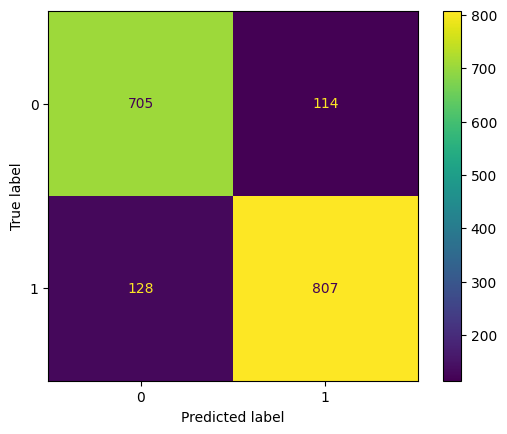

In [168]:
matrix1=confusion_matrix(y_test, prediction)
ConfusionMatrixDisplay(matrix1).plot()

Na grafe môžeme vidieť predikované hodnoty (predicted label) a spravne hodnoty (true label) ack. Vidíme na ňom, že vo veľa prípadoch priradil správnu hodnotu. Nespávne vyhodnotených nie je až tak veľa, však viac je takých, že správna hodnota bola 1 a vyhodnotil ju ako 0.

In [172]:
plt.figure(figsize=(50, 10))
tree.plot_tree(tree_c,
               filled=True,
               feature_names=X_test.columns,
               class_names=['0', '1']) 
plt.show()



InvalidParameterError: The 'feature_names' parameter of plot_tree must be an instance of 'list' or None. Got Index(['pct_wild_mouse', 'screen_height', 'pct_input', 'pct_scrandom',
       'pct_scroll_move', 'pct_click_product_info', 'wild_mouse_duration',
       'total_load_time', 'pct_click', 'screen_width', 'pct_doubleclick',
       'product_ean', 'pct_mouse_move', 'user_id', 'session_id',
       'pct_scroll_move_duration', 'scroll_move_total_rel_distance',
       'page_activity_duration', 'mouse_move_total_rel_distance',
       'browser_name', 'pct_rage_click', 'session_duration', 'pct_mouse_click',
       'job', 'race', 'age'],
      dtype='object') instead.

<Figure size 5000x1000 with 0 Axes>

Vyššie môžeme vidieť farebnú vizualizáciu decision tree.

In [ ]:
forest_c=RandomForestClassifier()
forest_c=forest_c.fit(X_train,y_train)
prediction2=forest_c.predict(X_test)

C:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
print(classification_report(y_test, prediction2, digits=3, target_names=["0", "1"]))

              precision    recall  f1-score   support

           0      0.941     0.918     0.930       819
           1      0.930     0.950     0.940       935

    accuracy                          0.935      1754
   macro avg      0.936     0.934     0.935      1754
weighted avg      0.935     0.935     0.935      1754



In [ ]:
print("accuracy is ",metrics.accuracy_score(y_test, prediction2))

accuracy is  0.935005701254276


In [ ]:
print("precision is ",metrics.precision_score(y_test, prediction2))

precision is  0.9298429319371728


In [ ]:
print("recall is ",metrics.recall_score(y_test, prediction2))

recall is  0.9497326203208556


Nasledne sme si natrénovali model pomocou random forest classifier, ukazali sme si classification report a vyhodnotili sme natrénované modeli pomocou accuraci, precision a recall. Podľa výsledkov môžeme vidieť, že výsledky sú velmi dobré. 

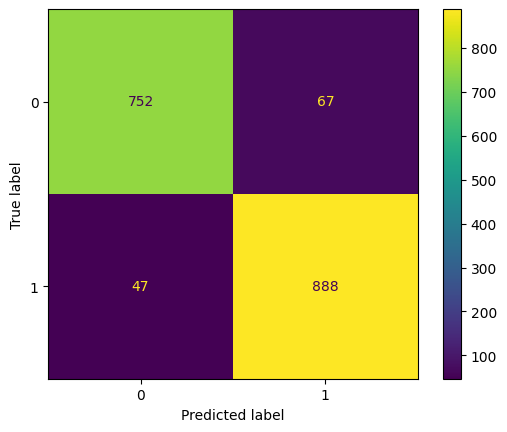

In [ ]:
matrix1=confusion_matrix(y_test, prediction2)
ConfusionMatrixDisplay(matrix1).plot()

Na grafe môžeme vidieť predikované hodnoty (predicted label) a spravne hodnoty (true label) ack. Vidíme na ňom, že vo veľa prípadoch priradil správnu hodnotu. Nespávne vyhodnotených nie je až tak veľa, však viac je takých, že správna hodnota bola 0 a vyhodnotil ju ako 1.

Porovnanie DecisionTree a Random Forest:

Random Forest mal vo všetkých metrikách (accuracy, precision, recall) lepšie hodnotenie ako Decision Tree, takže je pre nás výhodnejší. Výhodnejší je v každej metrike cca od 5% do 8%

Porovnanie s vytvoreným OneR

Náš OneR mal horšie hodnotenie vo všetkých metrikách ako RandomForest a aj DecisionTree. Náš vysledok je, že OneR je nevýdodnejší ako klasifikátori, ktoré sme skúšali.

## Optimalizácia alias hyperparameter tuning

Budeme preskúmavať hyperparametre clasifikátora RandomForest, pretože nám v predchádzajúcej úlohe priniesol najlepšie výsledky. Vybrali sme si tieto parametre:
1. n_estimators - počet stromov v lese, predvolena hodnota je 100
2. min_samples_split - minimálny počet vzoriek potrebný na rozdelenie vnútorného uzla, predvolená hodnota je 2
3. min_samples_leaf - minimálny počet vzoriek požadovaný na to, aby bol v uzle listu, predvolená hodnota je 1

Skúšali sme aj s dalšími parametrami ako napríklad max_depth, max_leaf_nodes, však tie skôr zmenšovali úspešnosť.

Random forest s predvolenými hodnotami:

In [ ]:
forest_class = RandomForestClassifier(n_estimators = 100,
                                      min_samples_split = 2,  
                                      min_samples_leaf = 1
                               ) 
forest_class = forest_class.fit(X_train,y_train) 
pridiction_default = forest_class.predict(X_test)

print("accuracy is ",metrics.accuracy_score(y_test, pridiction_default))

C:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


accuracy is  0.9310148232611174


Následne ideme nájsť najlepší výsledok s menením hyperparametrov

In [ ]:
n_estimators = [10, 25, 50, 100, 250]
min_samples_leaf = [1, 2, 5, 10, 20] 
min_samples_split = [2, 5, 10, 20] 

parametersF=dict(n_estimators = n_estimators,  
             min_samples_leaf = min_samples_leaf,
             min_samples_split = min_samples_split 
            )

In [ ]:
grit_s = GridSearchCV(forest_class, parametersF, cv=3, n_jobs=-1, scoring="accuracy")
grit_s.fit(X_train, y_train)
print("best estimator is ", grit_s.best_estimator_)
print("score is ", grit_s.best_score_)

C:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


best estimator is  RandomForestClassifier(min_samples_split=5)
score is  0.9265857218562324


In [ ]:
random_s = RandomizedSearchCV(forest_class, parametersF, random_state=71, scoring="accuracy", cv=3)
random_s.fit(X_train, y_train)
print("best estimator is ", random_s.best_estimator_)
print("score is ", random_s.best_score_)

C:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1152: DataConvers

best estimator is  RandomForestClassifier(min_samples_leaf=2, min_samples_split=5,
                       n_estimators=250)
score is  0.9268703782199236


Vyskúšali sme hľadanie najlepších hodnôt hyperparametrov dvoma technikami a to pomocou gridsearch a randomsearch. V oboch prípadoch nám vyšlo, že n_estimators=250. V random search min_samples_split=20. Ostatné parametre dávali najlepšie výsledky s predvolenými parametrami. V oboch prípadoch je úspešnosť nad 92%.

# Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu

In [175]:
X_train, X_test, y_train, y_test = train_test_split(training, target, test_size=0.2, random_state=42)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [177]:
forest_c=RandomForestClassifier()
forest_c=forest_c.fit(X_train,y_train)
prediction2=forest_c.predict(X_test)
print(classification_report(y_test, prediction2, digits=3, target_names=["0", "1"]))

/Users/markbartalos/.virtualenvs/iau/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

           0      0.933     0.912     0.922       819
           1      0.924     0.942     0.933       935

    accuracy                          0.928      1754
   macro avg      0.929     0.927     0.928      1754
weighted avg      0.928     0.928     0.928      1754



In [ ]:
SimpueSimpleImputer(strategy=imputer_type)